##### Soru 7:

##### Bir müşterimiz enerji üretimini planlamak üzere, enerji tüketimi üzerinden bir forecasting çalışması yapmak istediğini belirterek bize danıştı.

+ 1. Data Quality: Veri’de gözlemlediğiniz (missing, duplicates, out of range, vb.) durumlar var mıdır?

+ 2. Descriptive Statistics: Veriyi bir zaman serisi olarak plot ederek gözlemlerinizi paylaşınız (saatlik, aylık, sezonluk, haftanın günleri).

+ 3. Forecasting: İstediğiniz bir forecasting modeli ile verinizi “initialization” set, ve “holdout” set olarak ikiye bölün. Forecasting modelinizi “initialization” set üzerinde geliştirin Sonrasında da modelinizin perfomansını holdout set üzerinden değerlendirin. Değerlendirmede model parametrelerinizin ne anlama geldiğini ve parametrelerle ilgili verdiğiniz kararları açıklayın.

+ 4. Evaluation: Bu projede performans indikatörü olarak MAPE kullanılacaktır. Bu kavramı içgörüş/intuition kullanarak kısaca açıkladıktan sonra, kullandığınız ya da seçtiğiniz modeldeki sonuçları açıklayınız. Ek olarak tahmin, gerçekleşen ve fark olmak üzere bir plot yaratın ve yorumlayın.

+ 5. Proje kapsamında başka hangi verilere ihtiyaç olabilir? Ya da dikkat edilmesi dış faktörler neler olabilir?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

### 1-Data Quality
##### Veri Okuma

In [2]:
data=pd.read_csv("Hourly Load Data.csv")
df=data.copy()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32896 entries, 0 to 32895
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Datetime     32896 non-null  object 
 1   PJM_Load_MW  32896 non-null  float64
dtypes: float64(1), object(1)
memory usage: 514.1+ KB
None


,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0
3,1998-12-31 04:00:00,27596.0
4,1998-12-31 05:00:00,27888.0


##### EDA (Eksik veri-duplicated veri-outliers)

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PJM_Load_MW,32896.0,29766.427408,5849.769954,17461.0,25473.0,29655.0,33073.25,54030.0


+ Duplicated veriler:

In [4]:
df[df.duplicated(keep=False)]

,Datetime,PJM_Load_MW


+ Datetime dtype dönüşümü:

In [5]:
df["Datetime"]=pd.to_datetime(df["Datetime"])

+ Eksik veriler:

In [6]:
df.isnull().sum()

Datetime       0
PJM_Load_MW    0
dtype: int64

##### Outlier analizi:

+ Görüldüğü üzere üst limit aşılmış. Üst limitimizi aşan değerleri düşürelim. Eğer çok sayıda aşan olduysa düşürmiyeceğim, baskılayacağım.

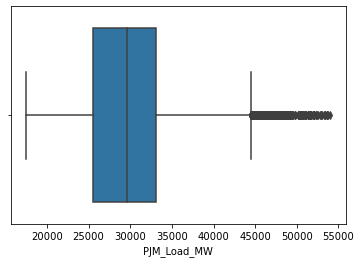

In [7]:
sns.boxplot(x="PJM_Load_MW", data=df)
plt.show()

##### Outlier'ları düşürmek için quantile fonksiyonuna başvurdum.

In [8]:
q1=df["PJM_Load_MW"].quantile(0.25)
q3=df["PJM_Load_MW"].quantile(0.75)
IQR = q3-q1
lower_limit=q1 - (1.5*IQR)
upper_limit=q3 + (1.5*IQR)

In [9]:
#Outlier'ların kaç adet olduğunu öğrenmek için;
df[df["PJM_Load_MW"]>upper_limit].shape[0]
#Sayısı gayet az. Bu yüzden düşürme yolunu tercih ediyorum.

567

In [10]:
#Bu aşamada outlier'ları düşürdüm.
df=df[~(df["PJM_Load_MW"]>upper_limit)]

### 2-Descriptive Statistics

### Yıllara Göre:
+ 1998 yılından 2002 yılına kadar yapılan ölçümlerde günlük elektrik tüketim ortalamalarının yıllar içerisinde artış yaptığı gözlemleniyor. 2002 yılına ait 1 adet gözlemimiz vardır. o yüzden 2002 yılı katılmamış haliyle de bir çizim paylaşıyorum.

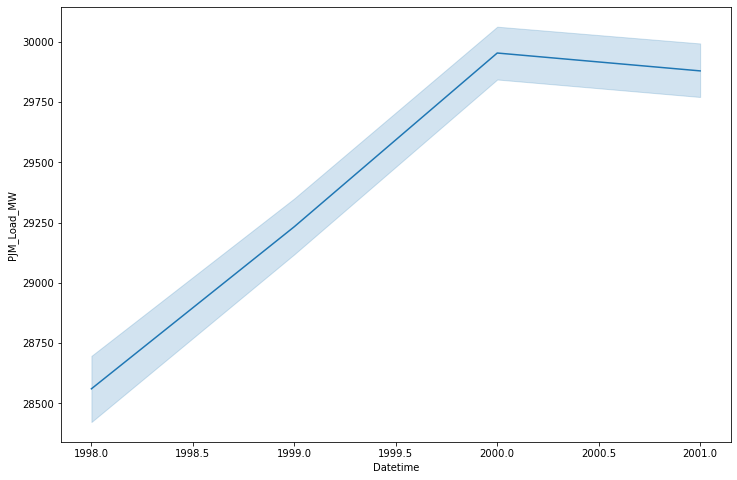

In [11]:
plt.figure(figsize=(12,8))
sns.lineplot(x=df[~(df["Datetime"]=="2002")]["Datetime"].dt.year, y="PJM_Load_MW", estimator="mean", data=df)
plt.show()

##### 2002'li görsel çarpıtılmış oluyor. Sebebi 1 adet gözlem olması. O yüzden yanlı bir trende yol açıyor. Üstteki görseli kullanmamız daha mantıklı.

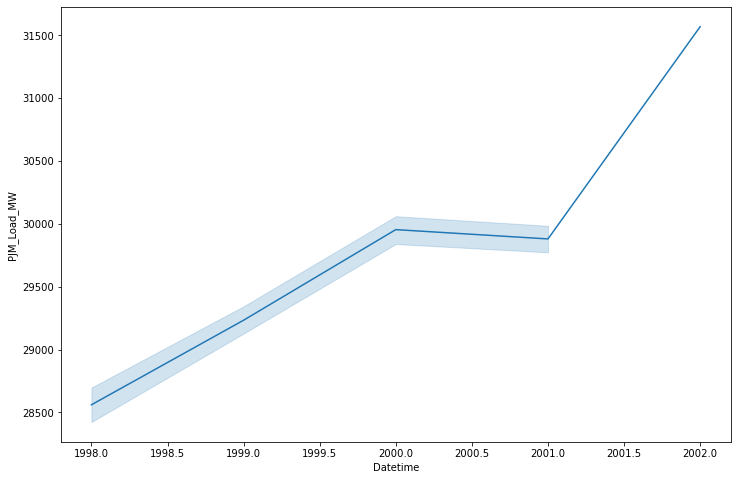

In [12]:
plt.figure(figsize=(12,8))
sns.lineplot(x=df["Datetime"].dt.year, y="PJM_Load_MW", estimator="mean", data=df)
plt.show()

### Çeyrekliklere Göre:
+ 1.ve 2.çeyrek kışı ve ilkbaharı temsil ediyor. 1.çeyrekten yani kıştan 2.çeyreğe yani ilkbahara geçerken enerji tüketim ortalamaları 30000-31000 bandından 28000-29000 bandına düşüyor.
+ 2.çeyrekten 3.çeyreğe yani yaza geçiş yaparken bu sefer tüm çeyreklerin ortalamasından daha fazla yani +32000 enerji tüketimi gözetleniyor.
+ En sonunda 3.çeyrekten 4.çeyreğe yani kışa geçerken enerji tüketim ortalamaları +32000 civarından 28000-29000 civarına doğru düşüşe geçiyor ve neredeyse 2.çeyreğin enerji tüketim ortalamasıyla eşleşiyor.

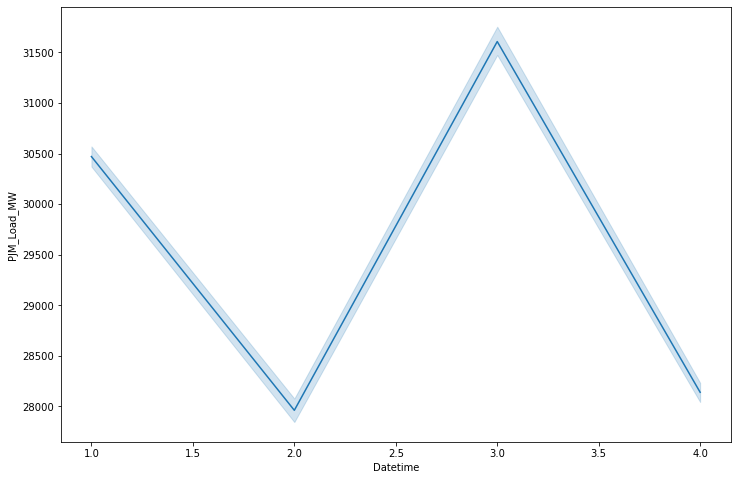

In [13]:
plt.figure(figsize=(12,8))
sns.lineplot(x=df["Datetime"].dt.quarter, y="PJM_Load_MW", estimator="mean",data=df)
plt.show()

### Aylara Göre:
+ Evet görüldüğü üzere "aylık" bazda tüketilen enerji ortalamaları yılın çeyreklerinde tüketilen enerji ortalamarıyla çok benzer bir dağılım izliyor. (İki dağılım grafiği tek grafikte paylaşılmıştır)
+ Çeyrekliğe göre çizilmiş ortalama enerji tüketim grafiğindeki her bir çeyreklik aylar baz alınarak çizilmiş grafikteki 3 aya denk gelmektedir. Bu yüzden son aylara doğru geçişlerde aylık bazda bir yükseliş görülürken çeyrekliklere göre bir düşüş görülmektedir çünkü 3. çeyrekliğin ortalaması 4. çeyreklikten daha azdır ama aylara göre 11. ve 12. ayın ortamaları 10. aya göre daha fazladır.

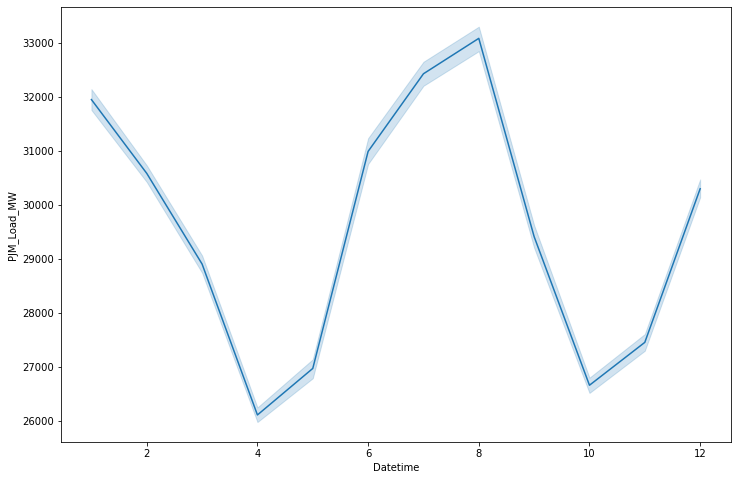

In [14]:
plt.figure(figsize=(12,8))
sns.lineplot(x=df["Datetime"].dt.month, y="PJM_Load_MW", estimator="mean",data=df)
plt.show()

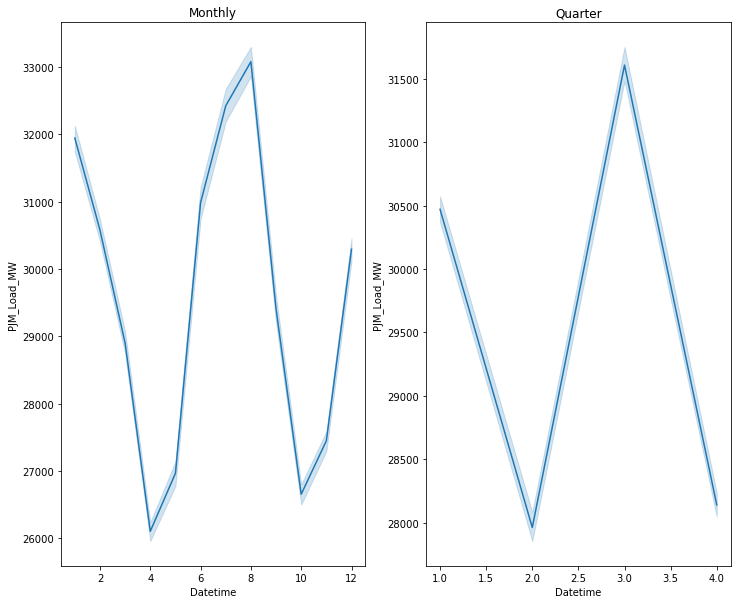

In [15]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
sns.lineplot(x=df["Datetime"].dt.month, y="PJM_Load_MW", estimator="mean",data=df)
plt.title("Monthly")
plt.subplot(1,2,2)
sns.lineplot(x=df["Datetime"].dt.quarter, y="PJM_Load_MW", estimator="mean",data=df)
plt.title("Quarter")
plt.show()

### Haftalara Göre:
+ Yine aynı quarter-month ilişkisine benzer bir ilişki görüyoruz. 3 ayın  1 çeyreklik ettiği gibi burada da 4 hafta bir ay ediyor. O yüzden haftalık bazda ki değişim aylık bazdaki değişime benziyor. 
+ Yapılacak çıkarımın aylık bazda değişimden pek bir farkı yok. Kışın ortalama enerji tüketimi ilkbaharın ortasına doğru düşüşe geçerken, ilkbaharın ortasından yazın sonuna kadar bir yükselişe geçer ve yazın sonundan sonbahara geçerken bir düşüşe geçer ve tekrar kışa yaklaşırken yükselmeye başlar. Tavan tüketim yaz aylarında yaşanıyor.

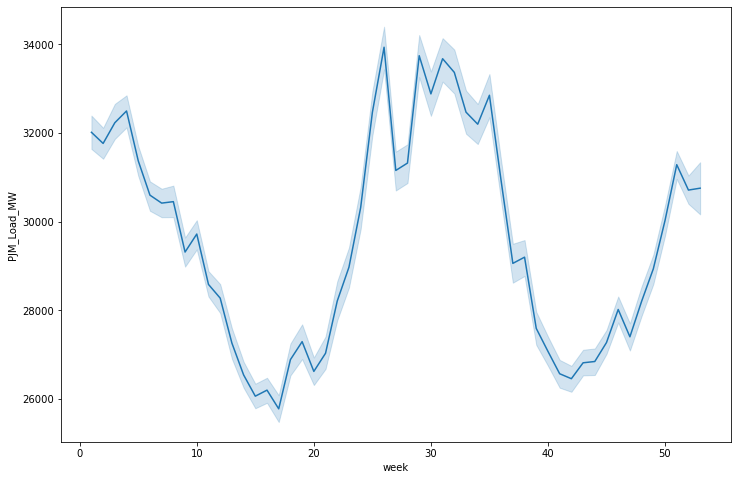

In [16]:
plt.figure(figsize=(12,8))
sns.lineplot(x=df["Datetime"].dt.isocalendar().week.astype("int64"), y="PJM_Load_MW",estimator="mean", data=df)
plt.show()

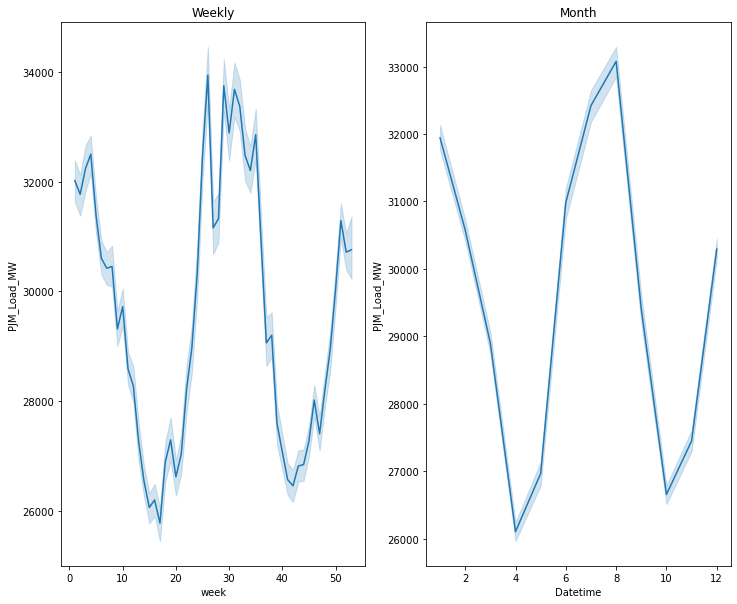

In [17]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
sns.lineplot(x=df["Datetime"].dt.isocalendar().week.astype("int64"), y="PJM_Load_MW",estimator="mean", data=df)
plt.title("Weekly")
plt.subplot(1,2,2)
sns.lineplot(x=df["Datetime"].dt.month, y="PJM_Load_MW", estimator="mean",data=df)
plt.title("Month")
plt.show()

### Günlere Göre:

+ Günlük ortalama elektrik tüketimi ayın ilk 5 günü düşüş trendinde, 5. gününden 10. gününe kadar bir yükseliş trendinde ve daha sonrasında 23.-24. gününe kadar 29500 seviyelerinde geziyor. 
+ 23.-24. günden 25. güne doğru bir düşüş trendi başlıyor ve günlük ortalama elektrik tüketimi 29000 seviyelerine geriliyor. 
+ 25.günden sonra ortalama elektrik tüketimi bir yükseliş trendine geçiyor ve bu seferde en yüksek değerine ayın 29. ve 30. günlerinde erişiyor ki bu seviye 30000-30500 MW'dır.

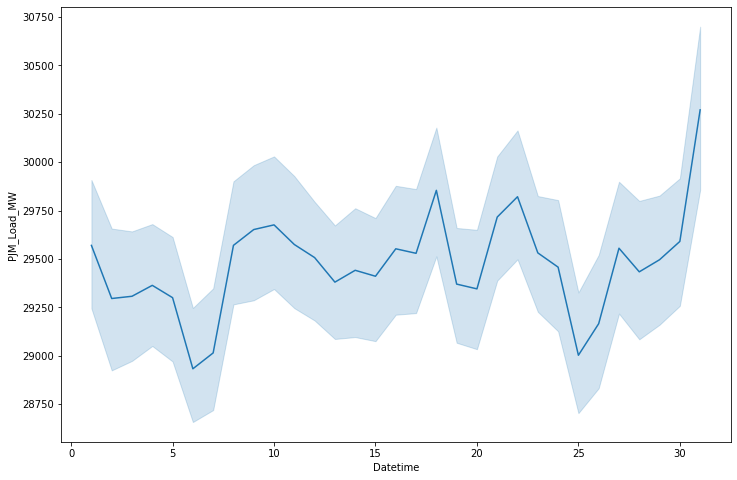

In [18]:
plt.figure(figsize=(12,8))
sns.lineplot(x=df["Datetime"].dt.day, y="PJM_Load_MW",estimator="mean",data=df)
plt.show()

+ Saatlik bazda ortalama enerji tüketimi grafiğini incelediğimiz zaman gece yarısından sabah 5'e kadar bir düşüş yaşanıyor. Sabah 5'ten 10'a kadar ortalama enerji tüketimi 32000 kadar çıkar ve sonra akşam 20:00'a kadar 32000-34000 civarında gezerken gece yarısı 24'e kadar 28000-30000 civarına düşer.
+ Ortalama tüketim sabah 10 akşam 20:00 arasında tavan noktasına ulaşır.

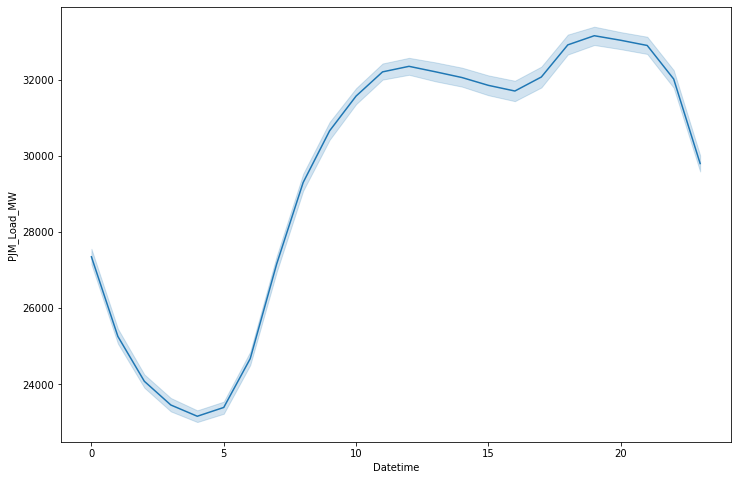

In [19]:
plt.figure(figsize=(12,8))
sns.lineplot(x=df["Datetime"].dt.hour, y="PJM_Load_MW", estimator="mean",data=df)
plt.show()

### 3-Forecasting

##### initialization ve holdout olmak üzere veri setimizi ikiye böldük. Ama isimlerini train ve test olarak değiştirdim.

##### train veri seti ile modelimi eğiticem ve test veri setimiz ile modelimizin tahmin gücünü test edicez.

+ train setimiz 2001-04-01 01:00:00 tarihinden daha küçük değerleri içeriyor.

+ test setimiz ise 2001-04-01 01:00:00 tarihinden daha büyük değerleri içeriyor.

In [20]:
train=df[df["Datetime"] <= ("2001-04-01 01:00:00") ]
test=df[df["Datetime"] > ("2001-04-01 01:00:00") ]

In [21]:
# test seti oranı %25
(test.shape[0]/train.shape[0])

0.24653942548679392

##### train ve test veri setimimizin ayrımını göstermek için bu görselden faydalanabiliriz.

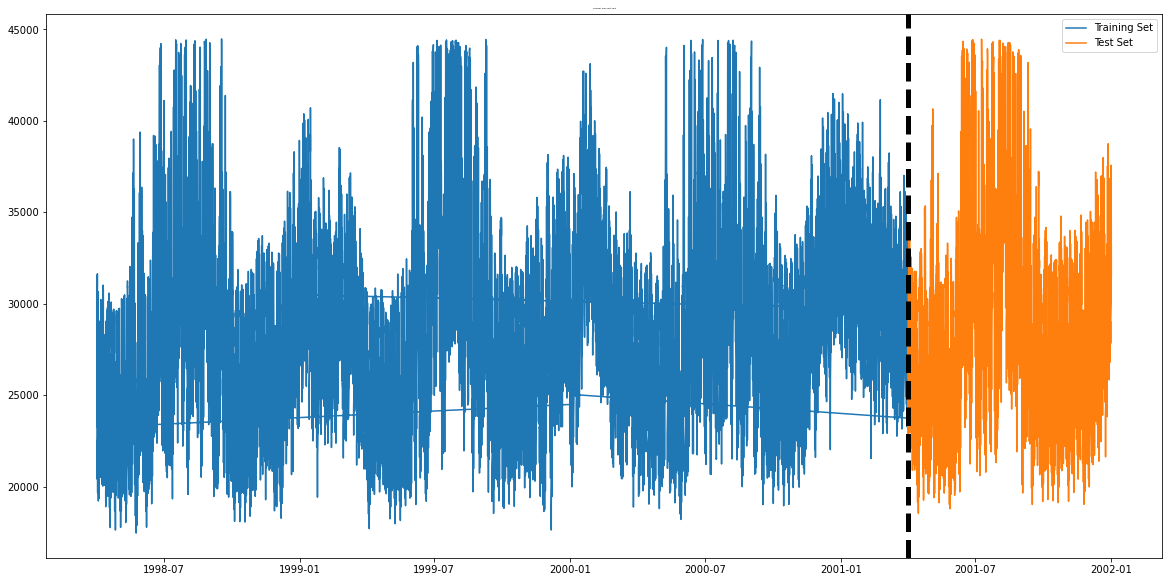

In [22]:
plt.figure(figsize=(20,10))
plt.plot(train.Datetime,train.PJM_Load_MW,label="Training Set")
plt.plot(test.Datetime,test.PJM_Load_MW,label="Test Set")
plt.title("Dataset Train/Test Split",fontsize=2)
plt.axvline("2001-04-01 01:00:00",color="black",linestyle="--",linewidth="5")
plt.legend()
plt.show()

##### Ben herhangi bir time series forecasting çalışması yürütmediğim için, makine öğrenmesi modeli üzerinden tahminleme çalışması yürüttüm.
+ Forecast modelimiz xgboost algoritmasını kullanmaktadır.

In [23]:
import xgboost as xgb

##### Bu aşamada train ve test veri setlerimize Datetime değişkeni üzerinden feature ekledik. 
##### Features:
+ Year, Quarter, Month, Week, Day ve Hour

In [24]:
train["Year"]=train["Datetime"].dt.year
train["Quarter"]=train["Datetime"].dt.quarter
train["Month"]=train["Datetime"].dt.month
train["Week"]=train["Datetime"].dt.isocalendar().week
train["Day"]=train["Datetime"].dt.day
train["Hour"]=train["Datetime"].dt.hour
train["Week"]=train["Week"].astype("int64")
train.drop("Datetime",axis=1,inplace=True)
train

,PJM_Load_MW,Year,Quarter,Month,Week,Day,Hour
0,29309.0,1998,4,12,53,31,1
1,28236.0,1998,4,12,53,31,2
2,27692.0,1998,4,12,53,31,3
3,27596.0,1998,4,12,53,31,4
4,27888.0,1998,4,12,53,31,5
...,...,...,...,...,...,...,...
32891,35209.0,2001,1,1,1,1,20
32892,34791.0,2001,1,1,1,1,21
32893,33669.0,2001,1,1,1,1,22
32894,31809.0,2001,1,1,1,1,23


In [25]:
test["Year"]=test["Datetime"].dt.year
test["Quarter"]=test["Datetime"].dt.quarter
test["Month"]=test["Datetime"].dt.month
test["Week"]=test["Datetime"].dt.isocalendar().week
test["Day"]=test["Datetime"].dt.day
test["Hour"]=test["Datetime"].dt.hour
test["Week"]=test["Week"].astype("int64")
test.drop("Datetime",axis=1,inplace=True)
test

,PJM_Load_MW,Year,Quarter,Month,Week,Day,Hour
24138,29001.0,2001,4,12,1,31,1
24139,28138.0,2001,4,12,1,31,2
24140,27830.0,2001,4,12,1,31,3
24141,27874.0,2001,4,12,1,31,4
24142,28427.0,2001,4,12,1,31,5
...,...,...,...,...,...,...,...
30731,30009.0,2001,2,4,13,1,20
30732,30783.0,2001,2,4,13,1,21
30733,29800.0,2001,2,4,13,1,22
30734,28096.0,2001,2,4,13,1,23


##### X_train, X_test  - y_train, y_test atamalarını yaptık ve modelimizi geliştirdik.

##### İlk defa forecast çalışması yürüttüğüm için bir araştırma yaptım ve xgbregressor algoritmasının time series forecast için kullanıldığını öğrendim. Daha sonra modeli oluşturma aşamasında evaulate ettim yani ufak bir geliştirme yaptım.

##### En düşük RMSE(Root Mean Square Error) puanı alacak şekilde modeli tune ettim. Bu yöntemi de yeni araştırdım ve öğrendim.

In [26]:
X_train=train.drop("PJM_Load_MW",axis=1)
y_train=train["PJM_Load_MW"]
X_test=test.drop("PJM_Load_MW",axis=1)
y_test=test["PJM_Load_MW"]
model=xgb.XGBRegressor(n_estimators=351
                       ,learning_rate=0.01
                       ,).fit(X_train
                              ,y_train
                              ,eval_set=[(X_train,y_train),(X_test,y_test)]
                              ,verbose=50)

[0]	validation_0-rmse:29665.25586	validation_1-rmse:29644.77148
[50]	validation_0-rmse:18133.93164	validation_1-rmse:18132.66992
[100]	validation_0-rmse:11243.89648	validation_1-rmse:11215.52246
[150]	validation_0-rmse:7202.79883	validation_1-rmse:7202.59228
[200]	validation_0-rmse:4914.43897	validation_1-rmse:4994.01367
[250]	validation_0-rmse:3699.54858	validation_1-rmse:3942.57031
[300]	validation_0-rmse:3104.58447	validation_1-rmse:3519.96460
[350]	validation_0-rmse:2832.50439	validation_1-rmse:3443.11963


##### Tahminlerimize en çok yön veren featurelarımızı öğrenmek ve görselleştirmek için feature_importances_ fonksiyonunu çağırdık ve bir dataframe'e atadık.

In [27]:
model.feature_importances_

array([0.03515954, 0.06269844, 0.15345863, 0.1035098 , 0.02359632,
       0.62157726], dtype=float32)

In [28]:
train.drop("PJM_Load_MW",axis=1).columns

Index(['Year', 'Quarter', 'Month', 'Week', 'Day', 'Hour'], dtype='object')

In [29]:
feature_importance=pd.DataFrame(data={"Importance":model.feature_importances_}
                                ,index=train.drop("PJM_Load_MW",axis=1).columns)
feature_importance

,Importance
Year,0.035160
Quarter,0.062698
Month,0.153459
Week,0.103510
Day,0.023596
Hour,0.621577


##### Burada hangi feature'ın daha önemli olduğunu görselleştirdik.

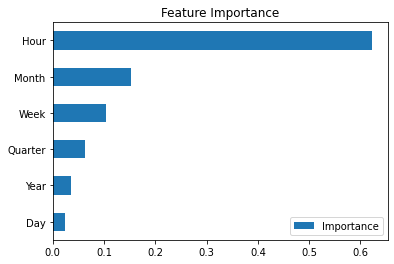

In [30]:
feature_importance.sort_values(by="Importance",ascending=True).plot(kind="barh"
                                                                    ,title="Feature Importance")
plt.show()

##### train veri setimizle geliştirdiğimiz model üzerinden test verimizi kullanarak tahmin gerçekleştirdik. Bu sayede modelimizin tahminleme başarısını ölçmüş olucaz.

+ test verimizle tahmin ettiğimiz verileri test veri setimizin içerisine Predictions özelliği adıyla atıyoruz.

In [31]:
test["Predictions"]=model.predict(X_test)

### 4-Evaulation
##### MAPE'yi hesaplamak için bir fonksiyon yazdım. 

+ Daha önce MAPE'yi kullanmadığım için stackoverflow üzerinden araştırma yaptım ve nasıl hesaplandığını öğrendim. 

In [32]:
def mape(y, y_pred): 
    y, y_pred = np.array(y), np.array(y_pred)
    return np.mean(np.abs((y - y_pred) / y)) * 100

##### MAPE değerimizi %8.969291 olarak hesapladık.

+ Her bir tahmin değerinin, gerçek değerden %8.969291 oranında farklılık göstereceğini MAPE sayesinde bulmuş oluyoruz.

In [33]:
print("MAPE: %f" % mape(y_test,test["Predictions"]))

MAPE: 8.969291


In [34]:
train["Predictions"]=model.predict(X_train)

##### Burada test ve train veri setleriyle gerçekleştirdiğimiz tahminlerin dağılımlarını görselleştirdik.

+ Sonuç olarak test verilerinin gerçek verilere göre yeterince iyi tahminleme yapamadığını görmüş olduk. Modelimizin daha iyi tahmin edebilmesi için yapabileceklerimi: Daha çok özellik ekleme veya çıkarma, farklı bir model kullanmak, modelimizi daha iyi tune etkem.

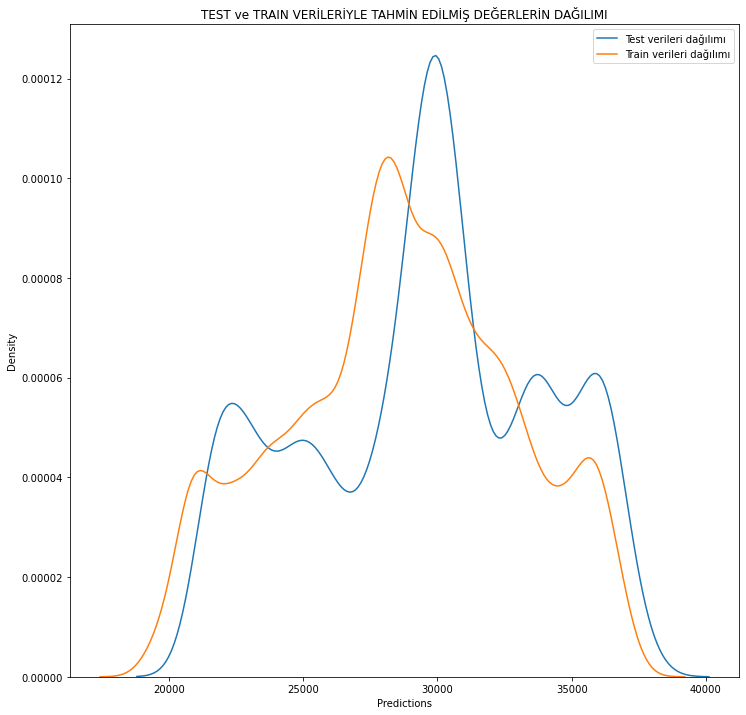

In [35]:
plt.figure(figsize=(12,12))
sns.kdeplot(test["Predictions"],label="Test verileri dağılımı")
sns.kdeplot(train["Predictions"],label="Train verileri dağılımı")
plt.legend()
plt.title("TEST ve TRAIN VERİLERİYLE TAHMİN EDİLMİŞ DEĞERLERİN DAĞILIMI")
plt.show()

##### Bu aşamada test veri setiyle yaptığım tahminleri df yani asıl veri setimize ekliyoruz ki tahminlerimizin asıl veri setimizi ne kadar iyi tahmin ettiğini görebilelim.

In [36]:
df=df.merge(test[["Predictions"]],how="left", left_index=True, right_index=True)

##### Burada benim gözüme ilk çarpan şey outliers yani aykırı değerler oldu. Bir diğer dikkat çeken şey ise aslında test değerlerimizin asıl verilerimizi düzgün tahmin ettiğidir fakat trendleri düzgün yakalayamamıştır.

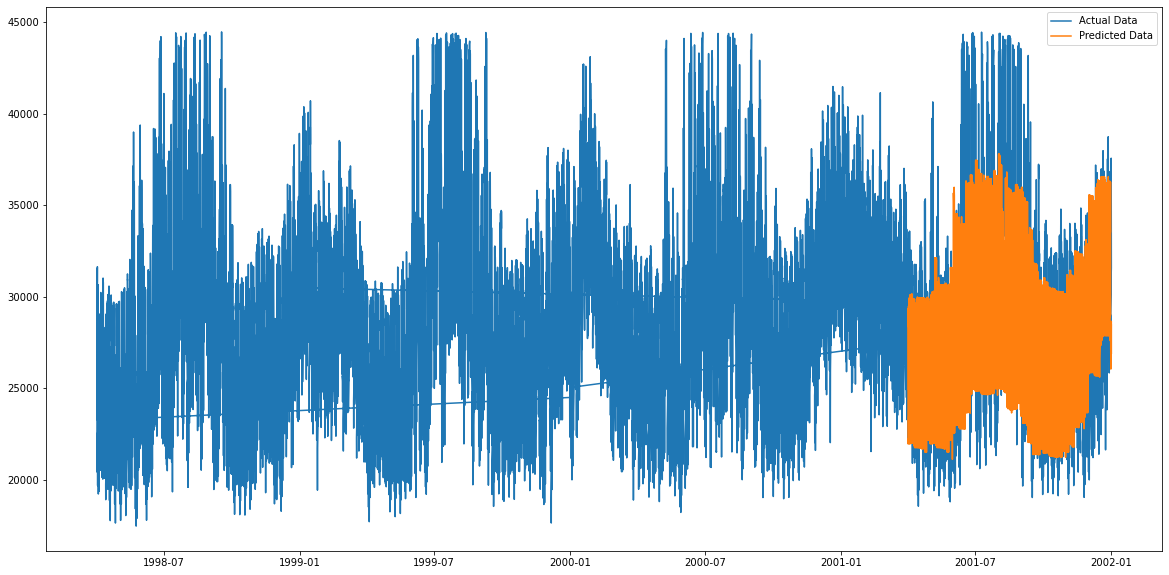

In [37]:
plt.figure(figsize=(20,10))
plt.plot(df.Datetime,df.PJM_Load_MW,label="Actual Data")
plt.plot(df.Datetime,df.Predictions,label="Predicted Data")
plt.legend()
plt.show()